# Covid19 Cases Prediction Using Facebook Prophet 

In [ ]:
#!pip install plotly

In [ ]:
#!pip install pystan==2.19.1.1 prophet

In [28]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from prophet import Prophet
from sklearn.metrics import r2_score

import plotly.offline as py
from plotly.offline import iplot
import plotly.io as pio
pio.renderers.default = 'iframe'

import warnings
warnings.filterwarnings("ignore")

In [11]:
# Import the data
# Entity: Country Name
# Date: Date on which records were observed
# Cases: Number of confirmed Covid-19 cases
# Deaths: Number of confirmed Covid-19 related deaths
# Daily tests: Number of tests taken in the country
# Iso_alpha: ISO code for countries
# Month: Month of observation

covid_df = pd.read_csv("covid_data.csv")
covid_df.head()

,Entity,Date,Cases,Deaths,Daily tests,iso_alpha,month
0,Mexico,2020-01-01,0.0,0.0,25.0,MEX,1
1,Mexico,2020-01-02,0.0,0.0,72.0,MEX,1
2,Mexico,2020-01-03,0.0,0.0,89.0,MEX,1
3,Thailand,2020-01-04,0.0,0.0,2.0,THA,1
4,Mexico,2020-01-04,0.0,0.0,45.0,MEX,1


In [12]:
covid_df.head(10)

,Entity,Date,Cases,Deaths,Daily tests,iso_alpha,month
0,Mexico,2020-01-01,0.0,0.0,25.0,MEX,1
1,Mexico,2020-01-02,0.0,0.0,72.0,MEX,1
2,Mexico,2020-01-03,0.0,0.0,89.0,MEX,1
3,Thailand,2020-01-04,0.0,0.0,2.0,THA,1
4,Mexico,2020-01-04,0.0,0.0,45.0,MEX,1
5,Thailand,2020-01-05,0.0,0.0,2.0,THA,1
6,Mexico,2020-01-05,0.0,0.0,81.0,MEX,1
7,Thailand,2020-01-06,0.0,0.0,5.0,THA,1
8,Mexico,2020-01-06,0.0,0.0,167.0,MEX,1
9,Mexico,2020-01-07,0.0,0.0,187.0,MEX,1


In [13]:
len(covid_df)

20645

# EXPLORATORY DATA ANALYSIS

In [14]:
covid_df.isnull().sum()

Entity         0
Date           0
Cases          0
Deaths         0
Daily tests    0
iso_alpha      0
month          0
dtype: int64

In [15]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20645 entries, 0 to 20644
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Entity       20645 non-null  object 
 1   Date         20645 non-null  object 
 2   Cases        20645 non-null  float64
 3   Deaths       20645 non-null  float64
 4   Daily tests  20645 non-null  float64
 5   iso_alpha    20645 non-null  object 
 6   month        20645 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 1.1+ MB


In [16]:
covid_df.describe()

,Cases,Deaths,Daily tests,month
count,2.064500e+04,20645.000000,2.064500e+04,20645.000000
mean,1.247184e+05,4693.475902,2.248130e+04,6.401259
std,6.068402e+05,17873.361923,1.055780e+05,2.399602
min,0.000000e+00,0.000000,-3.743000e+03,1.000000
25%,1.086000e+03,11.000000,9.700000e+01,4.000000
50%,8.698000e+03,196.000000,2.216000e+03,6.000000
75%,5.545200e+04,1522.000000,1.025400e+04,8.000000
max,9.047427e+06,229708.000000,1.492409e+06,10.000000


In [17]:
# Sort the dataframe by Date
covid_df = covid_df.sort_values(by = 'Date')

In [18]:
print('Total Number of Countries: {}'.format(covid_df['Entity'].nunique()))

Total Number of Countries: 83


In [19]:
print('Countries on which have data are:\n')

for i in covid_df['Entity'].unique():
      print(i+'\n')

Countries on which have data are:

Mexico

Thailand

Japan

United States

Vietnam

Switzerland

Nepal

France

Australia

Malaysia

Canada

Denmark

Israel

Czech Republic

Sri Lanka

India

Philippines

Finland

Italy

Sweden

United Kingdom

Belgium

South Africa

Guatemala

Iran

Morocco

Kuwait

Bahrain

Norway

Oman

Iraq

Austria

Croatia

Algeria

Pakistan

Romania

Greece

Iceland

Serbia

New Zealand

Senegal

Nigeria

Ireland

Ecuador

Portugal

Saudi Arabia

Dominican Republic

Indonesia

Bangladesh

Jordan

Tunisia

Chile

Poland

Togo

Libya

Slovenia

Hungary

Peru

Costa Rica

Paraguay

Colombia

Bulgaria

Panama

Bolivia

Jamaica

Turkey

Cuba

Trinidad and Tobago

Ghana

Kenya

Ethiopia

Mauritania

Namibia

Uruguay

Rwanda

Zambia

El Salvador

Madagascar

Zimbabwe

Uganda

Mozambique

Myanmar

Malawi



In [20]:
covid_df = covid_df.sort_values(by = 'Cases')
covid_df

,Entity,Date,Cases,Deaths,Daily tests,iso_alpha,month
0,Mexico,2020-01-01,0.0,0.0,25.0,MEX,1
1178,Thailand,2020-03-08,0.0,0.0,560.0,THA,3
158,Switzerland,2020-02-01,0.0,0.0,19.0,CHE,2
981,Libya,2020-03-04,0.0,0.0,3.0,LBY,3
192,Switzerland,2020-02-02,0.0,0.0,11.0,CHE,2
...,...,...,...,...,...,...,...
20244,United States,2020-10-27,8704524.0,225735.0,1229458.0,USA,10
20368,United States,2020-10-28,8779653.0,226723.0,1355447.0,USA,10
20410,United States,2020-10-29,8858024.0,227700.0,1366664.0,USA,10
20489,United States,2020-10-30,8946154.0,228668.0,1414156.0,USA,10


# INTERACTIVE DATA VISUALIZATION 

In [21]:
def interactive_plot(df, column_name, title):
    fig = px.line(title = title)
    for i in df['Entity'].unique():
        d = df[df['Entity'] == i]
        fig.add_scatter(x = d['Date'],y = d[column_name], name = i)
    fig.show()

In [29]:
interactive_plot(covid_df, 'Cases', 'Number of Covid cases')

In [30]:
interactive_plot(covid_df, 'Daily tests', 'Number of Daily tests')

In [31]:
interactive_plot(covid_df, 'Deaths', 'Number of Deaths')

# INTERACTIVE DATA VISUALIZATION 

In [32]:
covid_df

,Entity,Date,Cases,Deaths,Daily tests,iso_alpha,month
0,Mexico,2020-01-01,0.0,0.0,25.0,MEX,1
1178,Thailand,2020-03-08,0.0,0.0,560.0,THA,3
158,Switzerland,2020-02-01,0.0,0.0,19.0,CHE,2
981,Libya,2020-03-04,0.0,0.0,3.0,LBY,3
192,Switzerland,2020-02-02,0.0,0.0,11.0,CHE,2
...,...,...,...,...,...,...,...
20244,United States,2020-10-27,8704524.0,225735.0,1229458.0,USA,10
20368,United States,2020-10-28,8779653.0,226723.0,1355447.0,USA,10
20410,United States,2020-10-29,8858024.0,227700.0,1366664.0,USA,10
20489,United States,2020-10-30,8946154.0,228668.0,1414156.0,USA,10


In [33]:
fig = px.choropleth(covid_df, locations = "iso_alpha", # locations iso code
                    color = 'Cases', # column representing the color itensity
                    animation_frame = 'month') # timeframe for animation
fig.show()

In [34]:
# Covid deaths animation from January 2020 to November 2020
fig = px.choropleth(covid_df, locations = "iso_alpha", # locations iso code
                    color = 'Deaths', # column representing the color itensity
                    hover_name = "Entity", # column to add to hover information
                    animation_frame = 'month') # timeframe for animation

fig.show()

In [35]:
# Covid testing animation from January 2020 to November 2020
fig = px.choropleth(covid_df, locations = "iso_alpha", # locations iso code
                    color = 'Daily tests', # column representing the color itensity
                    hover_name = "Entity", # column to add to hover information
                    animation_frame = 'month') # timeframe for animation
fig.show()

In [36]:
fig = px.choropleth(covid_df, locations = "iso_alpha", #locations iso code
                    color = 'Daily tests', # column representing the color itensity
                    hover_name = "Entity", # column to add to hover information
                    animation_frame = 'Date') # timeframe for animation
fig.show()

# PREPARING THE DATA FOR PROPHET MODEL

---



In [37]:
covid_df

,Entity,Date,Cases,Deaths,Daily tests,iso_alpha,month
0,Mexico,2020-01-01,0.0,0.0,25.0,MEX,1
1178,Thailand,2020-03-08,0.0,0.0,560.0,THA,3
158,Switzerland,2020-02-01,0.0,0.0,19.0,CHE,2
981,Libya,2020-03-04,0.0,0.0,3.0,LBY,3
192,Switzerland,2020-02-02,0.0,0.0,11.0,CHE,2
...,...,...,...,...,...,...,...
20244,United States,2020-10-27,8704524.0,225735.0,1229458.0,USA,10
20368,United States,2020-10-28,8779653.0,226723.0,1355447.0,USA,10
20410,United States,2020-10-29,8858024.0,227700.0,1366664.0,USA,10
20489,United States,2020-10-30,8946154.0,228668.0,1414156.0,USA,10


In [38]:
# We are going to focus on US data for the forcasting


US_df = covid_df[covid_df['Entity'] == 'United States']  
US_df

,Entity,Date,Cases,Deaths,Daily tests,iso_alpha,month
52,United States,2020-01-23,1.0,0.0,0.0,USA,1
59,United States,2020-01-24,1.0,0.0,0.0,USA,1
43,United States,2020-01-21,1.0,0.0,0.0,USA,1
47,United States,2020-01-22,1.0,0.0,0.0,USA,1
77,United States,2020-01-26,2.0,0.0,0.0,USA,1
...,...,...,...,...,...,...,...
20244,United States,2020-10-27,8704524.0,225735.0,1229458.0,USA,10
20368,United States,2020-10-28,8779653.0,226723.0,1355447.0,USA,10
20410,United States,2020-10-29,8858024.0,227700.0,1366664.0,USA,10
20489,United States,2020-10-30,8946154.0,228668.0,1414156.0,USA,10


In [39]:
US_df = US_df[['Date','Cases']]


In [40]:
US_df

,Date,Cases
52,2020-01-23,1.0
59,2020-01-24,1.0
43,2020-01-21,1.0
47,2020-01-22,1.0
77,2020-01-26,2.0
...,...,...
20244,2020-10-27,8704524.0
20368,2020-10-28,8779653.0
20410,2020-10-29,8858024.0
20489,2020-10-30,8946154.0


In [41]:
# reset index
US_df.reset_index(inplace = True, drop = True)
US_df

,Date,Cases
0,2020-01-23,1.0
1,2020-01-24,1.0
2,2020-01-21,1.0
3,2020-01-22,1.0
4,2020-01-26,2.0
...,...,...
280,2020-10-27,8704524.0
281,2020-10-28,8779653.0
282,2020-10-29,8858024.0
283,2020-10-30,8946154.0


In [42]:
US_df.columns = ['ds','y']

In [43]:
train , test = US_df[ US_df['ds'] <= '2020-09-30'], US_df[US_df['ds'] >=  '2020-10-01']

In [44]:
train

,ds,y
0,2020-01-23,1.0
1,2020-01-24,1.0
2,2020-01-21,1.0
3,2020-01-22,1.0
4,2020-01-26,2.0
...,...,...
249,2020-09-26,7033430.0
250,2020-09-27,7078798.0
251,2020-09-28,7115046.0
252,2020-09-29,7148044.0


In [45]:
test

,ds,y
254,2020-10-01,7233043.0
255,2020-10-02,7277814.0
256,2020-10-03,7332285.0
257,2020-10-04,7382944.0
258,2020-10-05,7417845.0
259,2020-10-06,7458550.0
260,2020-10-07,7501612.0
261,2020-10-08,7549794.0
262,2020-10-09,7606594.0
263,2020-10-10,7664676.0


# PROPHET MODEL



In [46]:
m = Prophet()


In [47]:
# Create and fit the prophet model to the training data
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.91747


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1155.41     0.0252195       14703.5      0.2073      0.8875      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          1290    0.00217585       8415.09       0.336       0.336      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1343.92     0.0033394       1899.86           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1376.84     0.0043068       1553.34           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1391.84    0.00471987       1072.11           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

In [54]:
# We are going to forecast for 31 days, so we get the dataframe contain dates which includes our training
# dates as well as 31 days into the future, for forecasting.

future = m.make_future_dataframe(periods = 31)
future

,ds
0,2020-01-21
1,2020-01-22
2,2020-01-23
3,2020-01-24
4,2020-01-25
...,...
280,2020-10-27
281,2020-10-28
282,2020-10-29
283,2020-10-30


In [55]:
forecast = m.predict(future)

# 'yhat' is the mean predicted values and the 'yhat_lower' and 'yhat_upper' represent the lower and upper
# predicted boundaries

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
280,2020-10-27,8.301705e+06,8.124588e+06,8.466869e+06
281,2020-10-28,8.342879e+06,8.150731e+06,8.516471e+06
282,2020-10-29,8.383739e+06,8.185187e+06,8.571644e+06
283,2020-10-30,8.426007e+06,8.221765e+06,8.630810e+06
284,2020-10-31,8.470724e+06,8.252196e+06,8.686633e+06


In [51]:
from prophet.plot import plot_plotly, plot_components_plotly

# Ploting the forecasted data

plot_plotly(m, forecast)

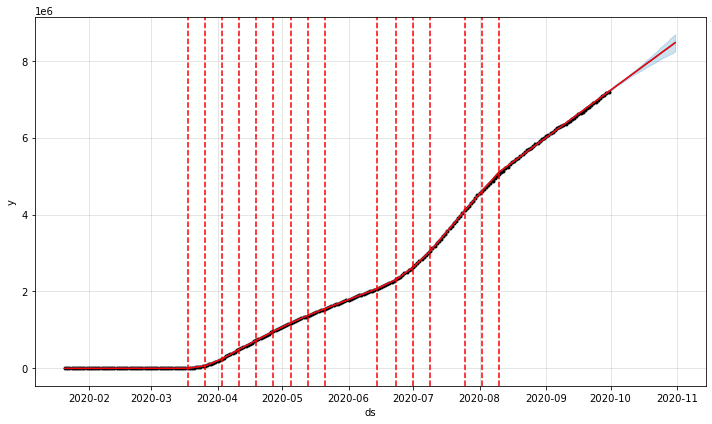

In [52]:
from prophet.plot import add_changepoints_to_plot

# This particular feature helps us identify trend changes that are infered by the model

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


In [53]:
future = m.make_future_dataframe(periods=60)
# Make prediction 
forecast = m.predict(future)
# Ploting the forecasted data
plot_plotly(m, forecast)

#  PERFORMANCE OF THE MODEL



In [56]:

score = r2_score(test['y'], forecast[forecast['ds'] >= '2020-10-01']['trend'])

print('R-Sqaure score is {}'.format(score))

R-Sqaure score is 0.7815643685009636


In [57]:
# Add the predicted values to the original dataframe for plotting purpose

US_df['predicted'] = forecast['trend']

In [58]:
US_df

,ds,y,predicted
0,2020-01-23,1.0,-1.483851e+02
1,2020-01-24,1.0,-1.416733e+02
2,2020-01-21,1.0,-1.349616e+02
3,2020-01-22,1.0,-1.282498e+02
4,2020-01-26,2.0,-1.215380e+02
...,...,...,...
280,2020-10-27,8704524.0,8.303778e+06
281,2020-10-28,8779653.0,8.344834e+06
282,2020-10-29,8858024.0,8.385889e+06
283,2020-10-30,8946154.0,8.426945e+06


In [59]:
# Function to plot the forecast and the origianl values for comparison

def interactive_plot_forecasting(df, title):
    fig = px.line(title = title)
    for i in df.columns[1:]:
        fig.add_scatter(x = df['ds'],y = df[i], name = i)
    fig.show()

In [60]:
interactive_plot_forecasting(US_df, 'Original Vs Predicted')